In [95]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data/')

test_number = 7
normalizationType = 'no' #['no', 'len', 'yRange']
# add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
add_info = '_test5'

filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'
print(filename_regular)
print(filename_mc)
print(filename_expected)

ds = xr.open_dataset(processed_data_path / filename_regular)
dsMC = xr.open_dataset(processed_data_path / filename_mc)
expected_ds = xr.open_dataset(processed_data_path / filename_expected)

test07_noNorm_test5_2025-05-08.nc
test07_MC_noNorm_test5_2025-05-08.nc
expected_test07_2025-05-08.nc


In [97]:
test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
binned_statistic(test_a, test_a, bins=3)[2]
# Define your intensity categories
intensity_labels = ['low', 'medium', 'high']

# Calculate bin indices (0, 1, or 2)
bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

# Map indices to labels
intensity_categories = np.array(intensity_labels)[bin_indices]
group_intensity = xr.DataArray(
    intensity_categories,
    coords={'time': expected_ds['time']},
    dims=['time']
)

expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)

In [98]:
def find_pareto_front(x, y, maximize_x=False, maximize_y=False):
    """
    Find the Pareto front for two objectives
    
    Parameters:
    -----------
    x, y : array-like
        Values of the two objectives
    maximize_x, maximize_y : bool
        Whether to maximize (True) or minimize (False) each objective
    
    Returns:
    --------
    pareto_indices : ndarray
        Indices of points on the Pareto front
    """
    import numpy as np
    
    # Copy arrays to avoid modifying originals
    x_values = np.copy(x)
    y_values = np.copy(y)
    
    # Convert maximization to minimization
    if maximize_x:
        x_values = -x_values
    if maximize_y:
        y_values = -y_values
    
    points = np.column_stack((x_values, y_values))
    pareto_indices = []
    
    for i, point in enumerate(points):
        if np.isnan(point).any():
            continue
            
        dominated = False
        for j, other_point in enumerate(points):
            if i != j and not np.isnan(other_point).any():
                # Check if other_point dominates point (smaller is better)
                if (all(other_point <= point) and any(other_point < point)):
                    dominated = True
                    break
        
        if not dominated:
            pareto_indices.append(i)
    
    return np.array(pareto_indices)


for intensity in ['low', 'high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values

        fig, ax = plt.subplots(2, 3, figsize=(8, 4))
        
        mc_hm = dsMC.sel(time=time_selection).median(dim=['MC','time'])['dcdt(HM)']
        uncertaintyRange_hm = dsMC.sel(time=time_selection).quantile(0.84, dim=['MC','time'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC','time'])['dcdt(HM)']      
        logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC','time'])['logprob(HM)']

        Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
        Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
        
        flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
        flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))

        # Find Pareto front
        pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                            y=flatNorm_logprob, 
                                                            maximize_x=False, maximize_y=False)
        coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
        distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                           (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
        # argmin_distance_pareto_uncertaintyRange_logprob = np.unravel_index(np.argmin(distance_pareto_uncertaintyRange_logprob), uncertaintyRange_hm.shape)
        argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
        
        best_pareto_x = coords_pareto_uncertaintyRange_logprob[0][argmin_distance_pareto_uncertaintyRange_logprob]
        best_pareto_y = coords_pareto_uncertaintyRange_logprob[1][argmin_distance_pareto_uncertaintyRange_logprob]

        hist_dcdt = dsMC.sel(time=time_selection,
                             cutoff=cutoff_coords[best_pareto_x], 
                             deadband=deadband_coords[best_pareto_y])['dcdt(HM)']
        # print(hist_dcdt)

        


        #### Plots ####
        ds.sel(time=time_selection)['dcdt(HM)'].median(dim='time').plot(ax=ax[0, 0], cmap='cividis')
        uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis')
        logprob_hm.plot(ax=ax[0, 2], cmap='viridis')

        ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                        Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                        s=5, c='red', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[best_pareto_x, best_pareto_y], 
                        Norm_logprob[best_pareto_x,best_pareto_y], s=5, c='blue', alpha=0.5)
        ax[1,0].plot([0, Norm_uncertaintyRange[best_pareto_x, best_pareto_y]], 
                     [0, Norm_logprob[best_pareto_x,best_pareto_y]], c='blue', alpha=0.5)
        
        # ax[1,1].hist(hist_dcdt, density=True, alpha=0.5)
        hist_dcdt.plot.hist(bins=100, density=True, alpha=0.5, ax=ax[1,1])

        fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')

        ax[0,0].set_title('Median dcdt(HM)')
        ax[0,1].set_title('Uncertainty Range')
        ax[0,2].set_title('Log Probability')
        fig.tight_layout()
        fig.show()
        # break

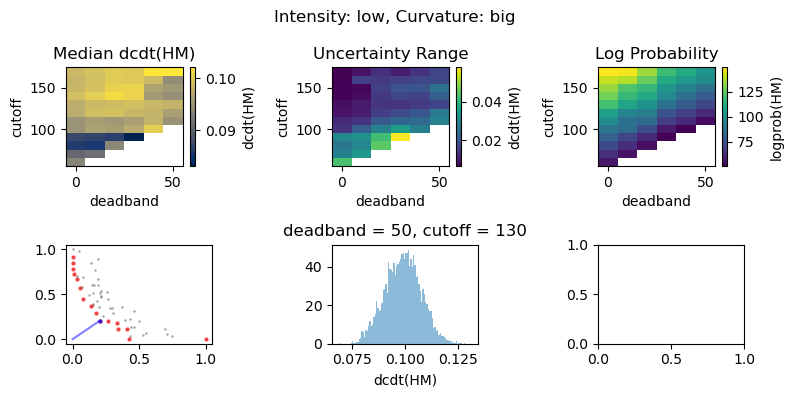

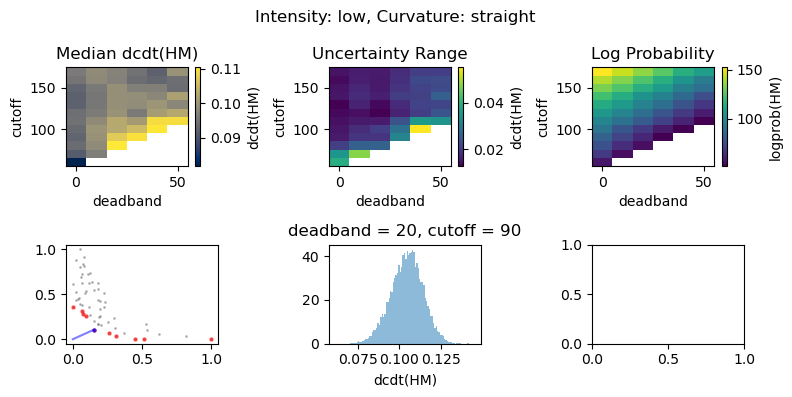

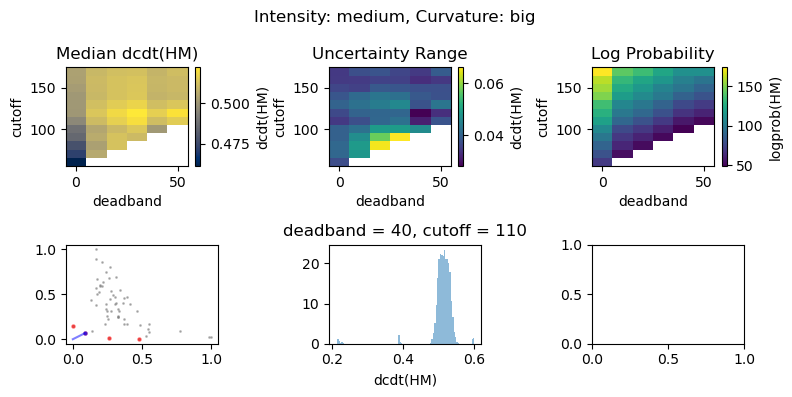

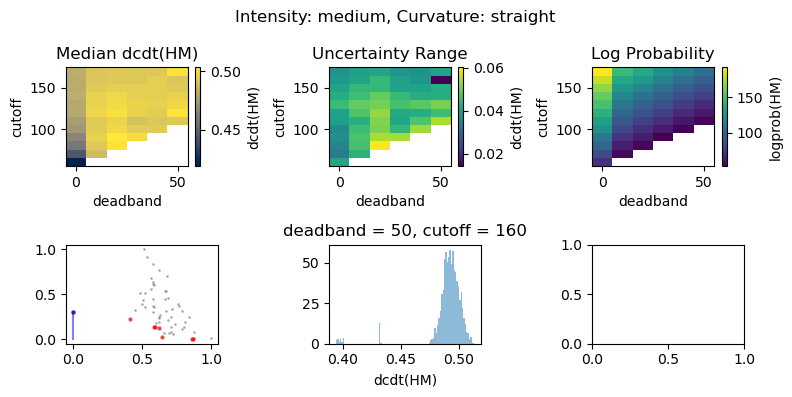

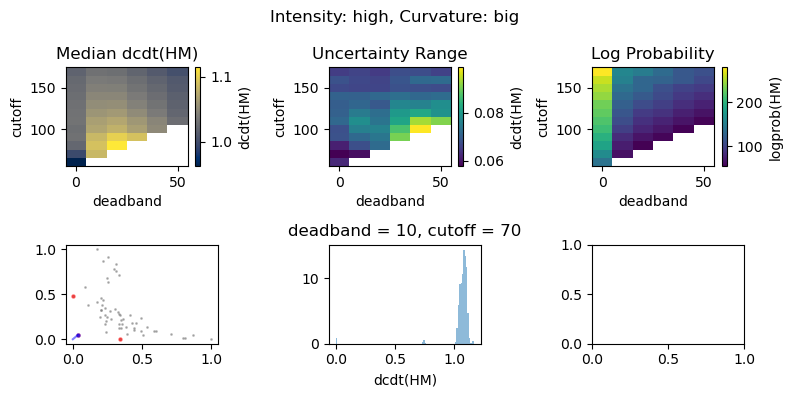

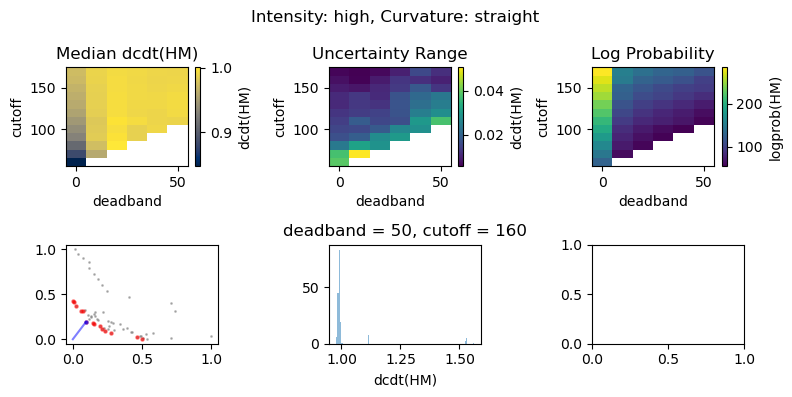

In [99]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values

        fig, ax = plt.subplots(2, 3, figsize=(8, 4))
        
        mc_hm = dsMC.sel(time=time_selection).median(dim=['MC','time'])['dcdt(HM)']
        uncertaintyRange_hm = dsMC.sel(time=time_selection).quantile(0.84, dim=['MC','time'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC','time'])['dcdt(HM)']      
        logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC','time'])['logprob(HM)']

        Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
        Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
        
        flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
        flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))

        # Find Pareto front
        pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                            y=flatNorm_logprob, 
                                                            maximize_x=False, maximize_y=False)
        coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
        distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                           (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
        # argmin_distance_pareto_uncertaintyRange_logprob = np.unravel_index(np.argmin(distance_pareto_uncertaintyRange_logprob), uncertaintyRange_hm.shape)
        argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
        
        best_pareto_x = coords_pareto_uncertaintyRange_logprob[0][argmin_distance_pareto_uncertaintyRange_logprob]
        best_pareto_y = coords_pareto_uncertaintyRange_logprob[1][argmin_distance_pareto_uncertaintyRange_logprob]

        hist_dcdt = dsMC.sel(time=time_selection,
                             cutoff=cutoff_coords[best_pareto_x], 
                             deadband=deadband_coords[best_pareto_y])['dcdt(HM)']
        # print(hist_dcdt)

        


        #### Plots ####
        ds.sel(time=time_selection)['dcdt(HM)'].median(dim='time').plot(ax=ax[0, 0], cmap='cividis')
        uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis')
        logprob_hm.plot(ax=ax[0, 2], cmap='viridis')

        ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                        Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                        s=5, c='red', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[best_pareto_x, best_pareto_y], 
                        Norm_logprob[best_pareto_x,best_pareto_y], s=5, c='blue', alpha=0.5)
        ax[1,0].plot([0, Norm_uncertaintyRange[best_pareto_x, best_pareto_y]], 
                     [0, Norm_logprob[best_pareto_x,best_pareto_y]], c='blue', alpha=0.5)
        
        # ax[1,1].hist(hist_dcdt, density=True, alpha=0.5)
        hist_dcdt.plot.hist(bins=100, density=True, alpha=0.5, ax=ax[1,1])

        fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')

        ax[0,0].set_title('Median dcdt(HM)')
        ax[0,1].set_title('Uncertainty Range')
        ax[0,2].set_title('Log Probability')
        fig.tight_layout()
        fig.show()
        # break

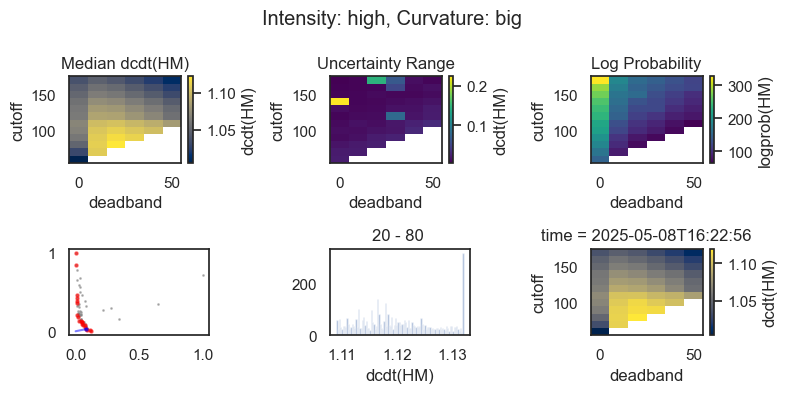

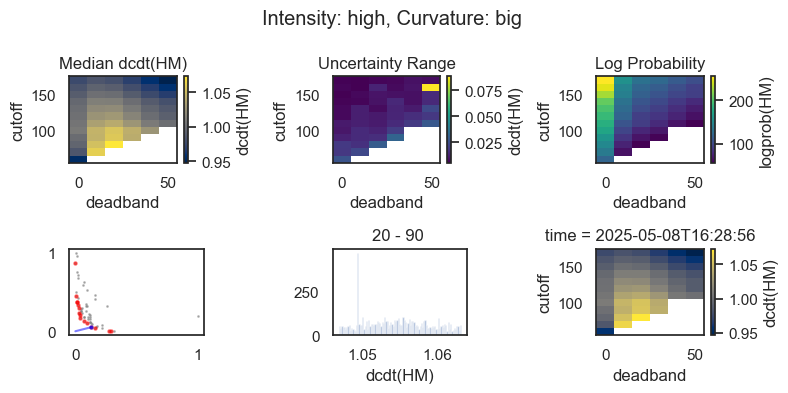

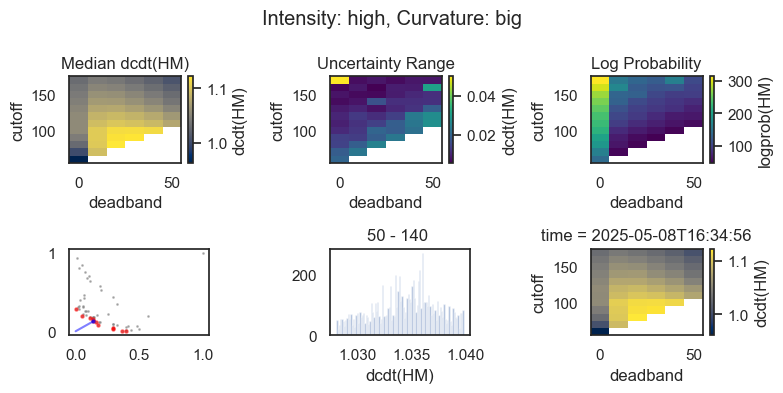

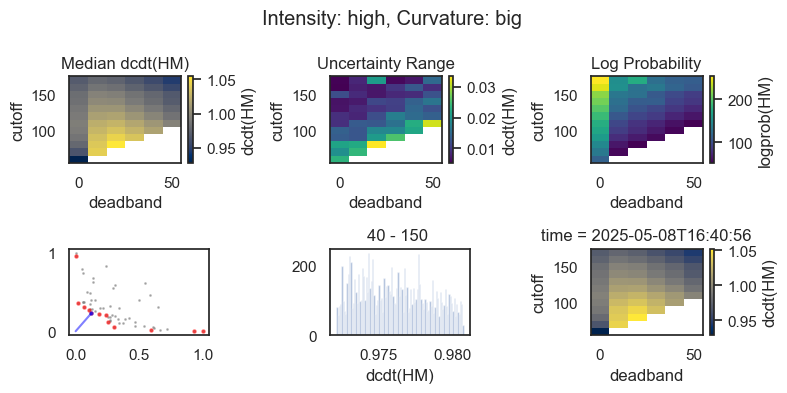

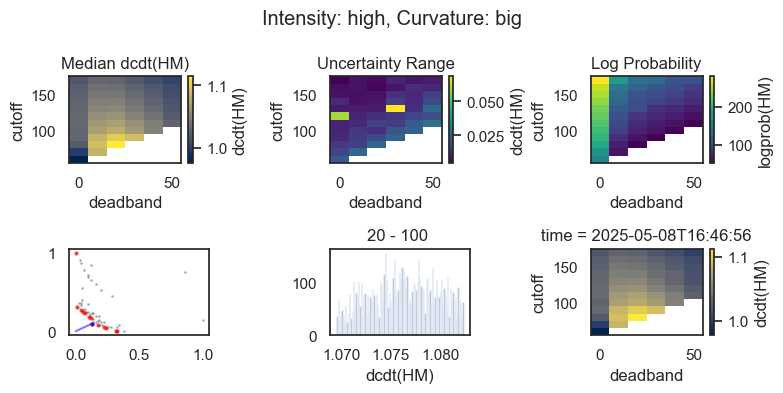

In [138]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = dsMC.coords['cutoff'], dsMC.coords['deadband']
    # print(cutoff_coords)
    # print()
    # print(deadband_coords)
    # print()

    for curve in np.unique(time_intensity['curvature'].values):
        all_time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values
        

        if intensity != 'high': # ['low', 'high']
            continue
        if curve != 'big': # ['straight', 'big']
            continue
        
        for time_selection in all_time_selection:
            try:
                fig, ax = plt.subplots(2, 3, figsize=(8, 4))
                
                mc_hm = dsMC.sel(time=time_selection).median(dim=['MC'])['dcdt(HM)']
                uncertaintyRange_hm = (dsMC.sel(time=time_selection).quantile(0.84, dim=['MC'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC'])['dcdt(HM)'])#/mc_hm
                logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC'])['logprob(HM)']
                logprob_hm = logprob_hm.where(logprob_hm != np.inf, np.nan)  # Replace inf with NaN for better handling

                Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
                Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
                
                flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
                flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
                
                # print(logprob_hm.values)
                # print(uncertaintyRange_hm.values)

                # Find Pareto front
                pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                                    y=flatNorm_logprob, 
                                                                    maximize_x=False, maximize_y=False)
                coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
                
                distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                                (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
                # argmin_distance_pareto_uncertaintyRange_logprob = np.unravel_index(np.argmin(distance_pareto_uncertaintyRange_logprob), uncertaintyRange_hm.shape)
                argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
                # print('argmin_distance_pareto_uncertaintyRange_logprob:', argmin_distance_pareto_uncertaintyRange_logprob)
                
                best_pareto_x = coords_pareto_uncertaintyRange_logprob[0][argmin_distance_pareto_uncertaintyRange_logprob]
                best_pareto_y = coords_pareto_uncertaintyRange_logprob[1][argmin_distance_pareto_uncertaintyRange_logprob]

                # print(best_pareto_x, best_pareto_y)
                # print(best_pareto_x, best_pareto_y)

                # print(deadband_coords[best_pareto_y].values,cutoff_coords[best_pareto_x].values)
                hist_dcdt = dsMC.sel(time=time_selection,
                                    cutoff=cutoff_coords[best_pareto_x].values, 
                                    deadband=deadband_coords[best_pareto_y].values)['dcdt(HM)']
                # print(hist_dcdt)
                hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)

                # hist_pareto_dcdt = dsMC.sel(time=time_selection)
                # print(cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]])\

                arbitrary_results = {'deadband':[0, 0, 30, 50, 0, 30, 50],
                                     'cutoff':[60, 60,120,170,60,120,170],  
                                     'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}


                                

                #### Plots ####
                ds.sel(time=time_selection)['dcdt(HM)'].plot(ax=ax[0, 0], cmap='cividis')
                # dsMC.sel(time=time_selection)['dcdt(HM)'].median(dim='MC').plot(ax=ax[0, 0], cmap='cividis')
                uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis', 
                                        #  vmin=uncertaintyRange_hm.quantile(0.16),
                                        #    vmax=uncertaintyRange_hm.quantile(0.84)
                                           )
                
                logprob_hm.plot(ax=ax[0, 2], cmap='viridis')

                ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)
                ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                                Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                                s=5, c='red', alpha=0.5)
                ax[1,0].scatter(Norm_uncertaintyRange[best_pareto_x, best_pareto_y], 
                                Norm_logprob[best_pareto_x,best_pareto_y], s=5, c='blue', alpha=0.5)
                ax[1,0].plot([0, Norm_uncertaintyRange[best_pareto_x, best_pareto_y]], 
                            [0, Norm_logprob[best_pareto_x,best_pareto_y]], c='blue', alpha=0.5)
                
                # ax[1,1].hist(hist_dcdt, density=True, alpha=0.5)
                hist_dcdt.plot.hist(bins=100, density=True, alpha=0.5, ax=ax[1,1])
                
                #### Arbitrary deadband and cutoff
                # ds.sel(time=time_selection,
                #        deadband=0, cutoff=60)['dcdt(HM)'].plot()
                ##################################


                dsMC.sel(time=time_selection)['dcdt(HM)'].median(dim='MC').plot(ax=ax[1,2], cmap='cividis')

                fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')

                ax[0,0].set_title('Median dcdt(HM)')
                ax[0,1].set_title('Uncertainty Range')
                ax[0,2].set_title('Log Probability')
                ax[1,1].set_title(f'{deadband_coords[best_pareto_y].values} - {cutoff_coords[best_pareto_x].values} ')
                fig.tight_layout()
                fig.show()
                # break
            except Exception as e:
                print('Error in plotting')
                print(e)
                continue

## Ridge plot


Arbitrary results:
[array(1.08708705), array(1.07914752), array(1.03204889), array(1.05625578), array(1.0109872)]

Arbitrary results:
[array(1.02859677), array(1.01581368), array(0.96928487), array(0.99145124), array(0.94810414)]

Arbitrary results:
[array(1.09068469), array(1.08640581), array(1.03042471), array(1.06555523), array(1.0079879)]

Arbitrary results:
[array(1.01657589), array(1.00749819), array(0.96581444), array(0.98486349), array(0.94670591)]

Arbitrary results:
[array(1.06162808), array(1.05061298), array(1.01975054), array(1.02113517), array(1.00209723)]



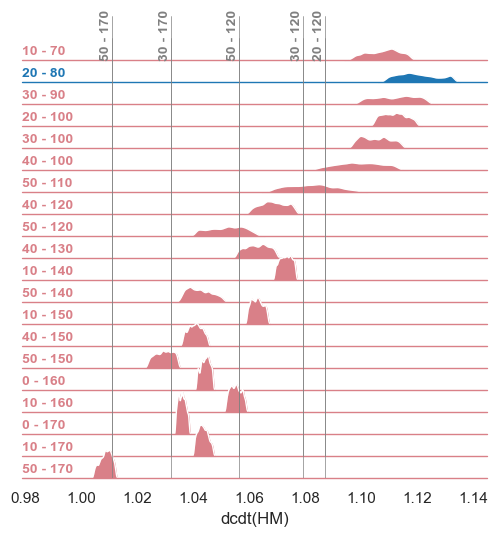

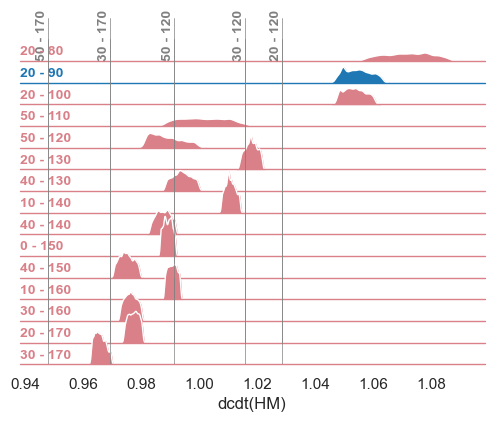

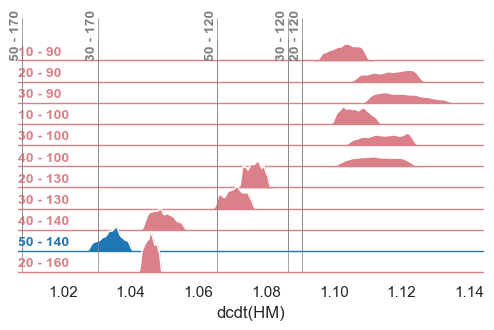

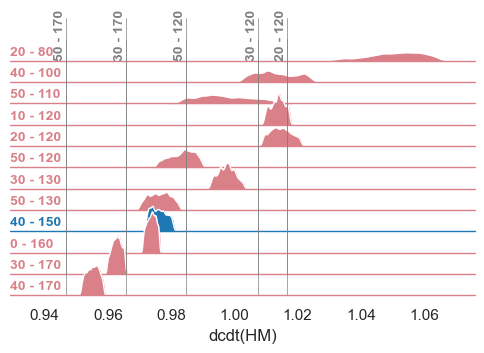

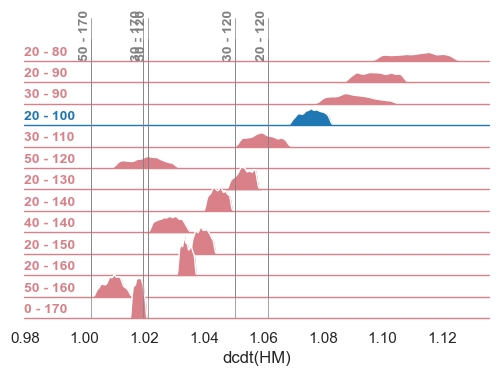

In [203]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = dsMC.coords['cutoff'], dsMC.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        all_time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values
        
        if intensity != 'high': # ['low', 'high']
            continue
        if curve != 'big': # ['straight', 'big']
            continue
        
        for time_selection in all_time_selection:
            try:
                # fig, ax = plt.subplots(2, 3, figsize=(8, 4))
                
                mc_hm = dsMC.sel(time=time_selection).median(dim=['MC'])['dcdt(HM)']
                uncertaintyRange_hm = (dsMC.sel(time=time_selection).quantile(0.84, dim=['MC'])['dcdt(HM)']-dsMC.sel(time=time_selection).quantile(0.16, dim=['MC'])['dcdt(HM)'])#/mc_hm
                logprob_hm = -dsMC.sel(time=time_selection).median(dim=['MC'])['logprob(HM)']
                logprob_hm = logprob_hm.where(logprob_hm != np.inf, np.nan)  # Replace inf with NaN for better handling

                Norm_uncertaintyRange = (uncertaintyRange_hm.values - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
                Norm_logprob = (logprob_hm.values - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))
                
                flatNorm_uncertaintyRange = (uncertaintyRange_hm.values.flatten() - np.nanmin(uncertaintyRange_hm)) / (np.nanmax(uncertaintyRange_hm) - np.nanmin(uncertaintyRange_hm))
                flatNorm_logprob = (logprob_hm.values.flatten() - np.nanmin(logprob_hm)) / (np.nanmax(logprob_hm) - np.nanmin(logprob_hm))

                # Find Pareto front
                pareto_uncertaintyRange_logprob = find_pareto_front(x=flatNorm_uncertaintyRange, 
                                                                    y=flatNorm_logprob, 
                                                                    maximize_x=False, maximize_y=False)
                coords_pareto_uncertaintyRange_logprob = np.unravel_index(pareto_uncertaintyRange_logprob, uncertaintyRange_hm.shape)
                
                distance_pareto_uncertaintyRange_logprob = np.sqrt((Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob])**2 + 
                                                                (Norm_logprob[coords_pareto_uncertaintyRange_logprob])**2)
                argmin_distance_pareto_uncertaintyRange_logprob = np.nanargmin(distance_pareto_uncertaintyRange_logprob)
                
                best_pareto_x = coords_pareto_uncertaintyRange_logprob[0][argmin_distance_pareto_uncertaintyRange_logprob]
                best_pareto_y = coords_pareto_uncertaintyRange_logprob[1][argmin_distance_pareto_uncertaintyRange_logprob]
                # print(deadband_coords[best_pareto_y].values,cutoff_coords[best_pareto_x].values)
                hist_dcdt = dsMC.sel(time=time_selection,
                                    cutoff=cutoff_coords[best_pareto_x].values, 
                                    deadband=deadband_coords[best_pareto_y].values)['dcdt(HM)']
                # print(hist_dcdt)
                hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)


                arbitrary_results = {'deadband':[20, 30, 30,50,50],
                                     'cutoff':[120, 120,170,120,170],  
                                     'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}
                # print(ds)
                for deadband, cutoff in zip(arbitrary_results['deadband'], arbitrary_results['cutoff']):
                    dcdt_arb = ds.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)
                    arbitrary_results['dcdt(HM)'].append(dcdt_arb['dcdt(HM)'].values)
                    arbitrary_results['R2'].append(dcdt_arb['R2(HM)'].values)

                # print(arbitrary_results)

                                
                hist_dcdt_pareto = dsMC.sel(time=time_selection,
                                            cutoff=cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]], 
                                            deadband=deadband_coords[coords_pareto_uncertaintyRange_logprob[1]])['dcdt(HM)']
                
                df_pareto = pd.DataFrame()
                for deadband, cutoff in zip(deadband_coords[coords_pareto_uncertaintyRange_logprob[1]].values, 
                                                                cutoff_coords[coords_pareto_uncertaintyRange_logprob[0]].values):
                    hist_dcdt = dsMC.sel(time=time_selection,
                                        cutoff=cutoff, 
                                        deadband=deadband)['dcdt(HM)']
                    hist_dcdt_range = hist_dcdt.quantile([0.16, 0.84], dim='MC')
                    hist_dcdt = hist_dcdt.where((hist_dcdt >= hist_dcdt_range[0]) & (hist_dcdt <= hist_dcdt_range[1]), drop=True)
                    df_pareto = pd.concat([df_pareto, hist_dcdt.to_dataframe().reset_index()], ignore_index=True)
                
                df_pareto['deadband-cutoff'] = df_pareto['deadband'].astype(str) + ' - ' + df_pareto['cutoff'].astype(str)
                # print(df_pareto)

                # pal = sns.cubehelix_palette(len(np.unique(df_pareto['deadband-cutoff'])), start=-0.25, light=.7)
                colors = ['#d98088' for _ in range(len(np.unique(df_pareto['deadband-cutoff'])))]
                colors = []
                for c in range(len(np.unique(df_pareto['deadband-cutoff']))):
                    if c == argmin_distance_pareto_uncertaintyRange_logprob:
                        colors.append('#1f77b4')
                    else:
                        colors.append('#d98088')

                pal = sns.color_palette(colors)


                g = sns.FacetGrid(data=df_pareto, row='deadband-cutoff', hue='deadband-cutoff',aspect=20, height=0.3, palette=pal)

                g.map(sns.kdeplot, 'dcdt(HM)', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=0.5)
                g.map(sns.kdeplot, 'dcdt(HM)', clip_on=False, color='w', lw=1, bw_adjust=1)
                g.refline(y=0, linewidth=1,linestyle='-', color=None, clip_on=False)
                
                def label2(x, color, label):
                    ax = plt.gca()
                    ax.text(0, .2, label, fontweight="bold", color=color, fontsize=10,
                            ha="left", va="center", transform=ax.transAxes)
                def add_text_first_row_only(x, **kwargs):
                    global row_counter
                    ax = plt.gca()
                    if row_counter == 0:
                        for i, a in enumerate(zip(arbitrary_results['dcdt(HM)'], arbitrary_results['deadband'], arbitrary_results['cutoff'])): 
                            if a[0] == np.nan:
                                continue
                            ax.text(a[0], 0.2, f"{a[1]} - {a[2]}", color='grey', ha='right', va='bottom', rotation=90, fontsize=10,fontweight='bold')
                    row_counter += 1

                # g.map(plt.axvline, x=1, color='black', linestyle='-', linewidth=1)
                print('Arbitrary results:')
                print(arbitrary_results['dcdt(HM)'])
                for a in arbitrary_results['dcdt(HM)']:
                    # print(a)
                    g.map(plt.axvline, x=a, color='grey', linestyle='-', linewidth=0.5)
                    # g.map(plt.text, x=a, y=0.2, s=f'{a:.2f}', color='black', ha='left', va='center')
                print()
                row_counter = 0
                g.map(add_text_first_row_only, 'dcdt(HM)')

                g.map(label2, 'dcdt(HM)')


                g.fig.subplots_adjust(hspace=-0.5)
                g.set_titles("")
                g.set(yticks=[], ylabel="")
                g.despine(bottom=True, left=True)
                # g.set(xlim=(0.9,1.15))
                xrange = (df_pareto['dcdt(HM)'].max() - df_pareto['dcdt(HM)'].min())*0.2
                g.set(xlim=(df_pareto['dcdt(HM)'].min()-xrange, df_pareto['dcdt(HM)'].max()+xrange/2))


                
            except Exception as e:
                print('Error in plotting')
                print(e)
                continue

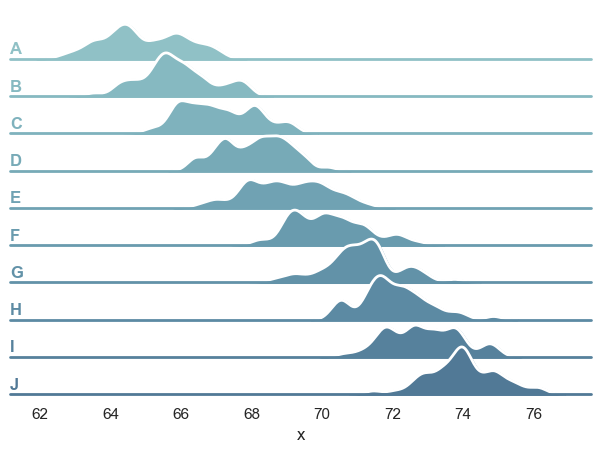

In [121]:
import pandas as pd
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(20, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# # Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

g.map(label, "x")

# # Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

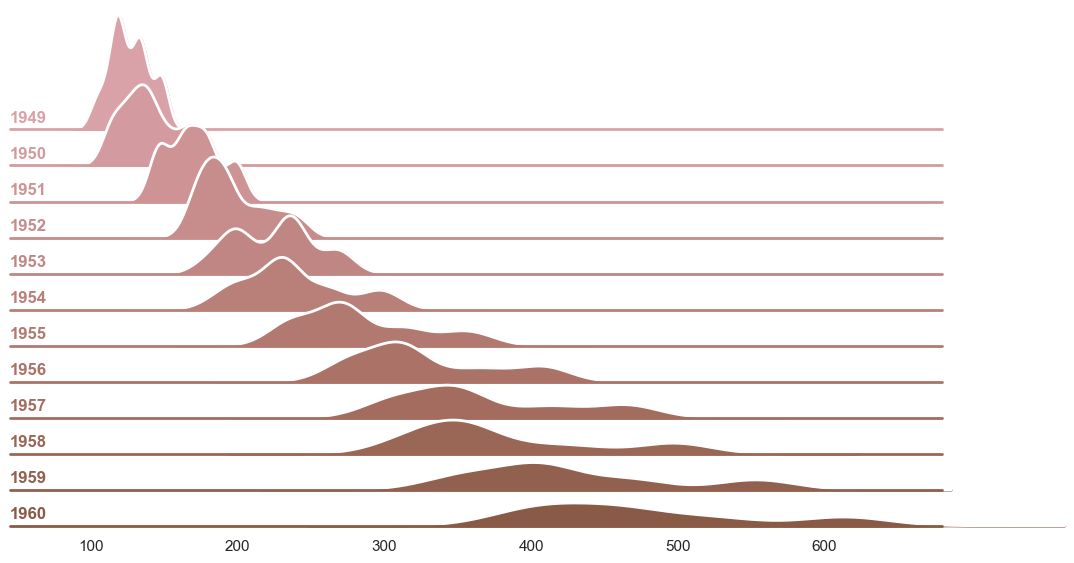

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

flights = sns.load_dataset('flights')
pal = sns.cubehelix_palette(len(flights["year"].unique()), start=1.4, rot=-.25, light=.7, dark=.4)
g = sns.FacetGrid(flights, row="year", hue="year", aspect=20, height=.5, palette=pal)

g.map(sns.kdeplot, "passengers", bw_adjust=.6, cut=5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "passengers", bw_adjust=.6, cut=5, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "year")
g.fig.subplots_adjust(hspace=-.7)
g.set(yticks=[], xlabel="", ylabel="", xlim=(None, 680), title="")
g.despine(bottom=True, left=True)
plt.show()